# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

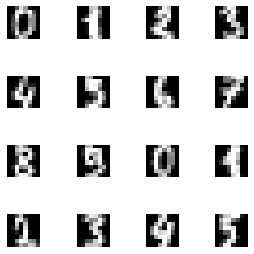

In [3]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4,4,figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4*i+j],(8,8))
        axs[i,j].imshow(img, cmap='gray')
        axs[i,j].axis('off')

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [4]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).

# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size # a list
  
    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions 
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
  
    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [5]:
#=========
# GRADING:
# 0 
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
#=========
# Implement a neural network (NN) classifier. 
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction='none') #it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # Return the indices with the highest probability which
        # are equivalent to the class labels because the labels are digits
        return torch.argmax(self.classnet(x), axis=1)

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        # Calculate the negative log likelihood loss based on the target values y
        # and how the classifier network classifies data x
        loss = self.nll(self.classnet(x), y.type(torch.LongTensor))
        
        if reduction == 'sum':
            return loss.sum()
        return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:** <em>The objective is to minimize the negative log likelihood loss. The nn.NLLLoss is the function being minimized. The Negative log likelihood function looks like $-\log\textbf{y}$ where $\textbf{y}$ is the probability assigned to the correct label by the classifier. If the value of $\textbf{y}$ is close to $1$, then $-\log\textbf{y}$ will be a small positive number but if the value of $\textbf{y}$ is close to 0, then the value $-\log\textbf{y}$ will be very large because it approaches $\infty$ as $\textbf{y}$ approaches $0$. Thus the further away from the correct classification, the greater the loss and the steeper the gradient. The reduction of the negative log likelihood loss comes into play when dealing with batches. It tells the function what to do with the multiple loss values corresponding to each instance in the batch. If reduction is average, then the loss is the mean of every loss value. Similarly if reduction is summation, then the loss values get added together.</em>

<em>Technically, the nn.NLLLoss is not the $-\log\textbf{y}$ function itself as the $\log$ of softmax is already taken by the neural network so it really only takes the negative and selects which $\log$ probability to use based on the target value but that is semantically equivalent to the above.</em>

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** <em>Yes, it is fine because the logarithm does not change the most probable label, it changes only the probability to the log-probability.</em>

### 2.2 Evaluation

In [6]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None, print_freq=10):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + '.model')
  
    model_best.eval()# set the model to the evaluation mode
    loss_test = 0.
    loss_error = 0.
    N = 0.
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction='sum')
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.*(y_pred == test_targets)
        loss_error = loss_error + (1. - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f'-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}')
    else:
        if epoch % print_freq == 0:
            print(f'Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}')

    return loss_test, loss_error

# An auxiliary function for plotting the performance curves
def plot_curve(name, signal, file_name='curve.pdf', xlabel='epochs', ylabel='nll', color='b-', test_eval=None):
    # plot the curve
    plt.plot(np.arange(len(signal)), signal, color, linewidth='3', label=ylabel +' val')
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(test_eval, xmin=0, xmax=len(signal), linestyles='dashed', label=ylabel +' test')
        plt.text(len(signal), test_eval, "{:.3f}".format(test_eval),)
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches='tight')
    plt.show()

### 2.3 Training procedure

In [7]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, print_freq=10):
    nll_val = []
    error_val = []
    best_nll = 1000.
    patience = 0
    
    # Evaluate model before training to show improvement
    loss_e, error_e = evaluation(val_loader, model_best=model, epoch=0, print_freq=print_freq)
    nll_val.append(loss_e)  # save for plotting
    error_val.append(error_e)  # save for plotting
    
    # Main training loop
    for e in range(num_epochs):
        model.train() # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e+1, print_freq=print_freq)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no 
        # progress is observed.
        if e == 0:
            torch.save(model, name + '.model')
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + '.model')
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [8]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [9]:
print("How do we get our data from Digits class? \n")
print(f"Feature example:\n{train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example:
[ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [10]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1,8,8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [11]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64   # input dimension

# -> model hyperparams
K = 10 # the number of labels
N_mlp = [128, 64, 32] # Number of neurons in MLP network layers
C_cnn = [1, 16, 64] # Number of channels in CNN network convolutional layers
N_cnn = [256, 128] # Number of neurons in CNN fully connected layers
shape_cnn = (1, 8, 8) # Shape the data needs to be reshaped to
KS_conv = 3 # Kernel size for convolutional layers
KS_pool = 2 # Kernel size for pooling layers
stride_conv = 1 # Stride for convolutional layers
stride_pool = 2 # Stride for pooling layers
padding = 'same' # Padding only for convolutional layers as pooling is used to reduce dimensionality

# Because I use multiple hidden layers, the two following hyperparameters are not used
M = 256  # the number of neurons in scale (s) and translation (t) nets
num_kernels = 32 # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=2.3092845589773994, val ce=0.9
Epoch: 10, val nll=0.32561375754220145, val ce=0.11714285714285715
Epoch: 20, val nll=0.20446181706019811, val ce=0.06285714285714286
Epoch: 30, val nll=0.15259198154721942, val ce=0.04857142857142857
Epoch: 40, val nll=0.1610276562826974, val ce=0.04857142857142857
Epoch: 50, val nll=0.15412885189056397, val ce=0.04857142857142857
Epoch: 60, val nll=0.15790290236473084, val ce=0.045714285714285714
-> FINAL PERFORMANCE: nll=0.30058552061418026, ce=0.09843400447427293


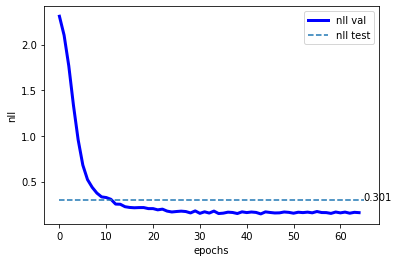

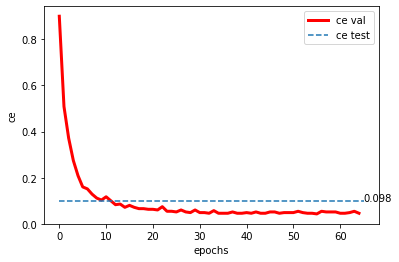


-> START classifier_cnn
Epoch: 0, val nll=2.7622908891950333, val ce=0.9057142857142857
Epoch: 10, val nll=0.16523533344268798, val ce=0.03428571428571429
Epoch: 20, val nll=0.10671797752380371, val ce=0.03142857142857143
Epoch: 30, val nll=0.08243072373526437, val ce=0.022857142857142857
Epoch: 40, val nll=0.08057695252554757, val ce=0.025714285714285714
Epoch: 50, val nll=0.07368496826716832, val ce=0.025714285714285714
Epoch: 60, val nll=0.06828709840774536, val ce=0.017142857142857144
Epoch: 70, val nll=0.0679630264214107, val ce=0.02
Epoch: 80, val nll=0.06079899387700217, val ce=0.017142857142857144
Epoch: 90, val nll=0.06012853349958147, val ce=0.017142857142857144
Epoch: 100, val nll=0.0591557788848877, val ce=0.017142857142857144
Epoch: 110, val nll=0.057772218244416376, val ce=0.014285714285714285
Epoch: 120, val nll=0.05582540788820812, val ce=0.014285714285714285
Epoch: 130, val nll=0.05599158874579838, val ce=0.014285714285714285
Epoch: 140, val nll=0.054301189269338336, 

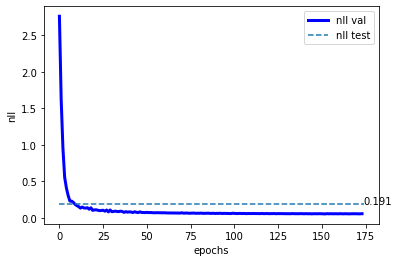

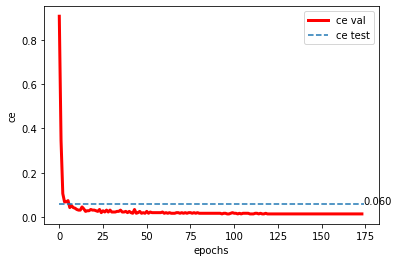

In [12]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = [
         'classifier_mlp',
         'classifier_cnn']

# loop over models
for name in names:
    print('\n-> START {}'.format(name))
  
    # Create a folder if necessary
    result_dir = os.path.join('results', name + '\\')
    if not(os.path.exists(result_dir)):
        os.makedirs(result_dir)

    # MLP
    if name[0:14] == 'classifier_mlp':
        #=========
        # GRADING: 
        # 0
        # 0.5pt if properly implemented
        #=========
        
        # Create a sequential network with 4 hidden layers
        # Activations between every layer are ReLU for their quick
        # computations and non-vanishing gradients
        # Since no neurons are dying, there is no need to switch to leaky ReLU
        # The final activation is log of softmax which is required by nn.NLLLoss
        
        # I have chosen this architecture on preliminary hyperparameter exploration and it has consistently
        # yielded the best results out if the handful of different architectures that I tried
        classnet = nn.Sequential(
                    nn.Linear(D, N_mlp[0]),
                    nn.ReLU(),
                    nn.Linear(N_mlp[0], N_mlp[1]),
                    nn.ReLU(),
                    nn.Linear(N_mlp[1], N_mlp[1]),
                    nn.ReLU(),
                    nn.Linear(N_mlp[1], N_mlp[2]),
                    nn.ReLU(),
                    nn.Linear(N_mlp[2], K),
                    nn.LogSoftmax(dim=1))
        
    # CNN
    elif name[0:14] == 'classifier_cnn':
        #=========
        # GRADING: 
        # 0
        # 0.5pt if properly implemented
        #=========
        
        # Create a sequential network with convolutional and pooling
        # layers first and fully connected layers after
        # Before the netowrk can process the images it has to reshape the data
        # so the very first layer does the reshaping
        # Afterwards the convolutional and pooling layers extract features and
        # the fully connected layers learn from these features
        # Between convolutional and fully connected layers a Flatten layer reshapes
        # the features back to one-dimensional
        
        # Similarly, here I too have explored some networks and this seems to work best
        # Not to say that it is optimal but it is adequate
        classnet = nn.Sequential(
                    Reshape(size=shape_cnn),
                    nn.Conv2d(C_cnn[0], C_cnn[1], KS_conv, stride=stride_conv, padding=padding),
                    nn.MaxPool2d(KS_pool, stride=stride_pool),
                    nn.Conv2d(C_cnn[1], C_cnn[2], KS_conv, stride=stride_conv, padding=padding),
                    nn.MaxPool2d(KS_pool, stride=stride_pool),
                    Flatten(),
                    nn.Linear(N_cnn[0], N_cnn[1]),
                    nn.ReLU(),
                    nn.Linear(N_cnn[1], K),
                    nn.LogSoftmax(dim=1))

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 

    # Training procedure
    nll_val, error_val = training(name=result_dir + name,
                                  max_patience=max_patience,
                                  num_epochs=num_epochs,
                                  model=model,
                                  optimizer=optimizer,
                                  training_loader=training_loader,
                                  val_loader=val_loader)
  
    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + '_test_loss.txt', "w")
    f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
    f.close()
    # create curves
    plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', test_eval=test_loss)
    plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=test_error)

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: <em>Both the loss and the classification error not only converge faster with the CNN rather than MLP but also converge to a better solution. The expected classification errors I have observed while running these algorithms a few dozen times is around 6% for the CNN and around 8% for the MLP. For this dataset with small digits the convergence is fairly similar but a small improvement is clearly visible in the CNN graphs over the MLP graphs despite the CNN usually taking a greater number of epochs.</em>

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: <em>I did notice that. CNNs are generally better at computer vision because they don't just learn from the raw data like simple MLPs. They are inspired from biological vision which has had billions of years to improve. The reason they are so effective is because the filters can identify specific features such as lines or shapes or even more complicated patterns like faces. These features are then passed along to the fully connected layers which no longer learn from raw data but can "reason" about the features such as "if there are two connected lines and an acute angle between them, it is a 1". Obviously no such conscious thinking as we know it occurs but the idea holds.</em>

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

### Dataset
Downloaded from http://ufldl.stanford.edu/housenumbers/ in format 2. The files were renamed to train.mat, test.mat, and extra.mat and moved to folder titled "SVHN dataset".

In [13]:
class Numbers(Dataset):
    THRESHOLD = 543949 # Used for seperating training data from validation data
    
    def __init__(self, mode='train', transforms=None):
        self.data, self.targets = self.get_data_and_targets(mode)
        self.transforms = transforms
    
    # Method for getting data based on mode
    def get_data_and_targets(self, mode):
        start, stop = None, None
        if mode == 'train':
            paths = [
                "SVHN dataset\\train.mat",
                "SVHN dataset\\extra.mat"
            ]
            stop = self.THRESHOLD
        elif mode == 'val':
            paths = [
                "SVHN dataset\\train.mat",
                "SVHN dataset\\extra.mat"
            ]
            start = self.THRESHOLD
        else:
            paths = ["SVHN dataset\\test.mat"]
        # Loading everything at once is not ideal as you have to store the
        # whole dataset in memory but because the dataset is not
        # comprised of individual files, it is difficult to set up a proper
        # pipeline and a TA gave me the greenlight for this solution
        return self.load_from_paths(paths, start=start, stop=stop)    
    
    def load_from_paths(self, paths, start=None, stop=None):
        X, y = [], []
        for path in paths:
            mat = scipy.io.loadmat(path)
            X.append(mat['X'])
            y.append(mat['y'])
        X = np.concatenate(X, axis=-1)
        y = np.concatenate(y).reshape(-1)
        X, y = self.shuffle(X, y, seed=0)
        # Since the dataset has data in format (W, H, C, N) but the convolutional
        # layers require format (N, C, W, H), the last axes are moved to the front
        return np.moveaxis(X[:,:,:,start:stop], [-1, -2], [0, 1]).astype(np.float32), y[start:stop]
    
    @staticmethod
    def shuffle(data, target, seed=None):
        size = target.size
        if seed is not None: np.random.seed(seed)
        ind = np.random.choice(range(size), size, replace=False)
        return data[:,:,:,ind], target[ind]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        # Select a sample from the provided indices
        sample_x = self.data[idx]
        sample_y = self.targets[idx]%10
        # I ended up not implementing any transformation despite playing
        # around with Gaussian blur
        # Still, the code is left for completeness
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

### Loading data

In [14]:
train_data = Numbers(mode="train")
val_data = Numbers(mode='val')
test_data = Numbers(mode='test')

training_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Data visualistation
Used to check that the data is loaded properly

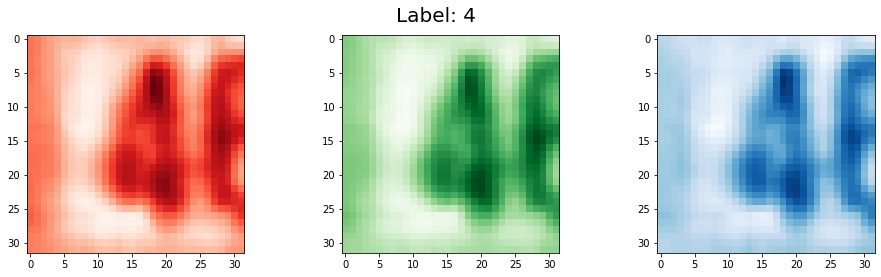

In [15]:
index = 0 # Index can be set to any integer in range [0, 543948]
imgs = train_data.__getitem__(index)
cmaps = ['Reds', 'Greens', 'Blues']

_, axs = plt.subplots(1, 3, figsize=(16, 4))

# Create an image for every RGB color channel
for ax, img, cmap in zip(axs, imgs[0], cmaps):
    ax.imshow(img, cmap=cmap)
plt.suptitle(f"Label: {imgs[1]}", fontsize=20)
plt.show()

### Running the model

#### Initialize hyperparameters

In [16]:
# ----------DATA HYPERPARAMETERS----------
C = 3 # input channels
K = 10 # the number of labels

# ----------MODEL HYPERPARAMETERS----------
Cs = [16, 32, 64] # Convolutional hidden layer channels
N = [1024, 256, 64]

# Kernels are symmetric because there is no special emphasis on horizontal or vertical sight
KS_conv = 3 # Kernel size for convolutional layers
KS_pool = 2 # Kernel size for pooling layers
stride_conv = 1 # Stride for convolutional layers
stride_pool = 2 # Stride for pooling layers
padding = 'same' # Padding only for convolutional layers as pooling is used to reduce dimensionality

# ----------TRAINING HYPERPARAMETERS----------
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 100 # max. number of epochs
max_patience = 2 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped
print_freq = 2 # how often to print the results of an epoch

#### Model architecure
The convolutional neural network model can be seperated into two parts: the convolutional and pooling layers and the fully connected layers. In my model the input is first processed by 3 2-dimensional convolutional layers alternating with 3 2-dimensional pooling layers. I use max pooling instead of average pooling layers as they are both faster and they select only the most salient part of the kernel which may be advantageous over an average blur.
The convolutional layers extract features from the data while the pooling layers reduce dimensionality. To not lose precious information, every convolutional layer also expands the number of outgoing channels.

Once all the features are extracted they are flattened as the shape of the data is no longer useful to the following layers. Once flattened the fully connected layers take the features and make a prediction. The hidden FCLs all have a number of neurons between the number of features and the size of the output which is recommended as a rule of thumb when designing neural networks.

The activation function I use between the FCLs is ReLU. I use it for the same reason as in the earlier networks. It is incredibly fast requiring only 2 FLOPs per output in activation layer ([Murphy, 2016](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjO9e6btuz3AhXQDOwKHRFUBgwQFnoECAYQAQ&url=https%3A%2F%2Fwww.microway.com%2Fdownload%2Fwhitepaper%2FAn_Overview_of_Convolutional_Neural_Network_Architectures_for_Deep_Learning_fall2016.pdf&usg=AOvVaw0aQ3VVqIUHNb-y6p4r6OMT)) and it does not suffer from vanishing gradients like the sigmoid and hyperbolic tangent activation functions. It may though still suffer from dying neurons which can be circumvented by using leaky ReLU. I do not need to use leaky ReLU though as I have implemented another component which mitigates the dying neuron issue.

The component I am referring two is l2 reqularization. Specifying weight decay in the optimizer overrides the default value of 0 which means that a small penalty is added to the loss for every non-zero weight parameter. The penalty rises with the square of each weight so the larger the weight, the much greater the loss incurred. This helps with overfitting as the model is penalized for memorizing the data with arbitrarily large weights regardless if they are positive or negative. Thus, this also inadvertently prevents dying neurons with ReLU as those require large negative values.

Finally, the last activation layer is LogSoftmax. What that does is first takes the softmax of the last layer which converts it to probabilities and then takes the logarithm of that so that the input is valid for the nn.NLLLoss function.

-> START training
Epoch: 0, val nll=3.442106485749465, val ce=0.8513542580122107
Epoch: 2, val nll=0.17259916645566278, val ce=0.04725425635764986
Epoch: 4, val nll=0.14112008600891082, val ce=0.037376528400536076
Epoch: 6, val nll=0.13665958392961605, val ce=0.03352140174390708
Epoch: 8, val nll=0.14483957273423667, val ce=0.033786131471400915
Epoch: 10, val nll=0.16131731530708743, val ce=0.03367031221562236
-> FINAL PERFORMANCE: nll=0.2645721767686156, ce=0.06430547019053473


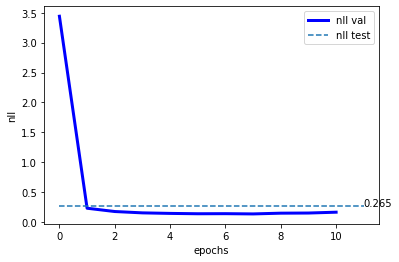

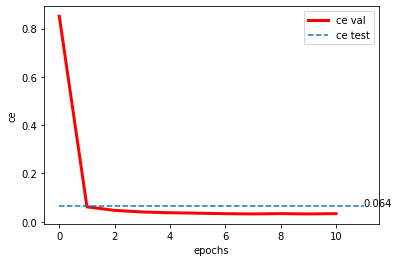

In [17]:
print('-> START training')

result_dir = 'results\\classifier_cnn_SVHN\\'

if not os.path.exists(result_dir):
    os.makedirs(result_dir)

classnet = nn.Sequential(
            nn.Conv2d(C, Cs[0], KS_conv, stride=stride_conv, padding=padding),
            nn.MaxPool2d(KS_pool, stride=stride_pool),
            nn.Conv2d(Cs[0], Cs[1], KS_conv, stride=stride_conv, padding=padding),
            nn.MaxPool2d(KS_pool, stride=stride_pool),
            nn.Conv2d(Cs[1], Cs[2], KS_conv, stride=stride_conv, padding=padding),
            nn.MaxPool2d(KS_pool, stride=stride_pool),
            Flatten(),
            nn.Linear(N[0], N[1]),
            nn.ReLU(),
            nn.Linear(N[1], N[2]),
            nn.ReLU(),
            nn.Linear(N[2], K),
            nn.LogSoftmax(dim=1))

# Init ClassifierNN
model = ClassifierNeuralNet(classnet)

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 

# Training procedure
nll_val, error_val = training(name=result_dir + name,
                              max_patience=max_patience,
                              num_epochs=num_epochs,
                              model=model,
                              optimizer=optimizer,
                              training_loader=training_loader,
                              val_loader=val_loader,
                              print_freq=print_freq)

# The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)

# write the results to a file
f = open(result_dir + 'classifier_cnn_SVHN_test_loss.txt', "w")
f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
f.close()

# create curves
plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', test_eval=test_loss)
plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=test_error)

### Analysis
Because the data set is very large, even after 1 epoch the classification error is very low. For this reason I have updated the training function to evalueate the model before any training is done to show that there is actual great improvement. The classifier usually finishes learning around epoch 10 and gets an expected 6% test data classification error which is not as good as the state of the art networks but acceptable and certainly usable.

For most of the epochs the validation loss keeps decreasing while validation classification error remains more or less static. It can be assumed that during these epochs the model is decreasing the weights in such a way as to minimize the l2 regularization penalty while maintaining proper classification. This is a good sign of reducing overfitting.

Overall, the convergence is very fast from the point of view the number of epochs but this is only because of the very large dataset size (~600000 instances). In reality it takes around 30 minutes on my device to train the model which is substantially longer than the earlier networks in this assignment. While this period of time is not particularly long when compared to some networks such as LSTMs, it still makes hyperparameter selection a tedious and tiresome endeavor. For this reason it can be assumed that given greater computational power, this model could imporved by checking a greater number of hyperparameter combinations.